post_process_of hhalign

In [1]:
import pickle as pkl
from typing import List,Dict,Tuple,Union
from pathlib import Path
import pandas as pd
from itertools import accumulate,tee,chain

In [3]:
if 0:
    #[ [[k[1][:7] for k in j[1]] for j in  i[1] if len(j[1])>0] for i in search_result[:5] ]
    pklfile='blit_out.pkl'#'blit_out_all_other.pkl'
    search_result:List[Tuple[Path,List[Tuple[Path,List[str]]]]]=pkl.load(open(pklfile,'rb'))
    domains=[]
    for i in search_result:
        for j in i[1]:
            for k in j[1]:
                domains.append(k[1][:7])
    pkl.dump(set(domains),open('demo_4_domains.pkl','wb'))        
    len(set(domains))

1218

In [33]:
#'blit_out.pkl'
if 0:
    pklfile='blit_out_all_other.pkl'
    search_result:List[Tuple[Path,List[Tuple[Path,List[str]]]]]=pkl.load(open(pklfile,'rb'))
    domains=[]
    for i in chain(pkl.load(open('blit_out_all_other.pkl','rb')),pkl.load(open('blit_out.pkl','rb'))):
        for j in i[1]:
            for k in j[1]:
                domains.append(k[1][:7])
    print(len(set(domains)))
    pkl.dump(set(domains),open('rna_virus_domains.pkl','wb'))
    
#python batch_hhalign_used_domain.py

4391

In [2]:
from collections import  namedtuple

Hit=namedtuple('Hit',('domain_accession','domain_annotation',
    'prob','eval','pval','score','ss','begin','end','hmmbegin','hmmend','hmmlength'))
SegMeta=namedtuple('SegMeta',("transannot",'seg_b','seg_e'))

def split_hit_line(hit_line:str)->List[str]:
    i=hit_line
    assert len(i)>94
    return [i[:4],i[4:34],i[34:40],i[40:48],i[48:56],i[56:63],
            i[63:69],i[69:74],i[74:85],i[85:94],i[94:]]

def parse_splited_hit_line(hit:List[str])->Hit:
    domain_accession,*_=hit[1].split(';')
    domain_accession=domain_accession.split('.')[0].strip()
    if len(_)>0:
        domain_annotation=_[0].strip()
    else:
        domain_annotation=domain_accession
        
    prob=float(hit[2].strip())
    e=float(hit[3].strip())
    p=float(hit[4].strip())
    score=float(hit[5].strip())
    ss=float(hit[6].strip())
    begin,end=[int(i.strip())-1 for i in hit[8].split('-')]
    hmmbegin,hmmend=[int(i.strip())-1 for i in hit[9].split('-')]
    hmmlength=int(hit[10].strip().strip('(').strip(')'))
    h=Hit(domain_accession=domain_accession,domain_annotation=domain_annotation,
        prob=prob,eval=e,pval=p,score=score,ss=ss,
        begin=begin,end=end,hmmbegin=hmmbegin,hmmend=hmmend,hmmlength=hmmlength)
    return h

In [3]:
hmmaligns:List[Tuple[str,List[List[str]]]]=pkl.load(open('hmm_align-demo_4.pkl','rb'))

In [4]:
len(set([i[0] for i in hmmaligns]))==len([i[0] for i in hmmaligns])

True

In [5]:
#WARNING: index begin with 0!
import numpy as np
def parse_hmmalign_res(qurey:str,splited_hit_lines:List[List[str]]):
    o=[]
    for h in splited_hit_lines:
        hit=parse_splited_hit_line(h)
        o.append(hit)
    _=pd.DataFrame(o)
    _['query']=qurey
    reidx=np.insert(np.arange(len(_.columns)-1),0,len(_.columns)-1)
    return _[_.columns[reidx]]

In [6]:
cct=pd.concat([parse_hmmalign_res(*i) for i in hmmaligns],ignore_index=True)

In [7]:
cct['tmp']=list(zip(cct['query'],cct['domain_accession']))


In [8]:
probs=cct.groupby('tmp')['prob'].max()
# probs[probs<0.5]=0.
probs=probs.to_frame().reset_index()
probs['query'],probs['domain_accession']=[i[0] for i in probs['tmp']],[i[1] for i in probs['tmp']]

In [56]:
if 0:
    probs['prob'].hist()
    plt.title('prob distribution in 4-demo families hhalign')

In [23]:
clans=pd.read_csv('Pfam-A.clans.tsv',delimiter='\t',header=None)
clans.columns=['domain','clan','clan_name','domain_name','domain_annotation']
clans.set_index('domain',inplace=True)

In [19]:
clans

,clan,clan_name,domain_name,domain_annotation
domain,,,,
PF00001,CL0192,GPCR_A,7tm_1,7 transmembrane receptor (rhodopsin family)
PF00002,CL0192,GPCR_A,7tm_2,7 transmembrane receptor (Secretin family)
PF00003,CL0192,GPCR_A,7tm_3,7 transmembrane sweet-taste receptor of 3 GCPR
PF00004,CL0023,P-loop_NTPase,AAA,ATPase family associated with various cellular...
PF00005,CL0023,P-loop_NTPase,ABC_tran,ABC transporter
...,...,...,...,...
PF21818,CL0771,YaaA-like,DUF6884,Family of unknown function (DUF6884)
PF21819,CL0125,Peptidase_CA,DUF6885,Family of unknown function (DUF6885)
PF21820,NaN,NaN,DUF6886,Family of unknown function (DUF6886)


In [21]:
import networkx as nx
if 1:
    cluster_threshold=90
    # _=probs['query'].to_list()
    # def tmp(x):
    #     if x[1] in _:
    #         return True
    #     else:
    #         False
    pairs=probs[(probs['prob']>=cluster_threshold) & probs['domain_accession'].isin(probs['query'])]['tmp'] #(probs['tmp'].apply(tmp))
    print(len(pairs))
    G=nx.Graph()
    G.add_edges_from(pairs)
    _=list(nx.connected_components(G))
    # print(len(_))
    with open('inspect_cluster','w') as f:
        f.write('myclust\tdomain\tdomain_name\tdomain_annotation\tpfam_clan\tclan_name\n')
        for i,clust in enumerate(_):
            for n in clust:
                try:
                    f.write(f'{i}\t{n}\t{clans.loc[n,'domain_name']}\t{clans.loc[n,'domain_annotation']}\t{clans.loc[n,'clan']}\t{clans.loc[n,'clan_name']}\n')
                except:
                    f.write(f'{i}\t{n}\tXX\tXX\tXX\tXX\n')
            # f.write(f'clust: {i} \n')
            #     for n in clust:
            #         f.write(f'clust: {i} \n'):            
            # if len(i)>2:
            #     print(len(i))

28346


In [27]:
myclust=pd.read_csv('inspect_cluster',delimiter='\t')
myclust[myclust['myclust']==0]['clan_name'].unique()

array(['Zn_Beta_Ribbon', 'PKinase', nan, 'P-loop_NTPase', 'C2H2-zf',
       'TPR', 'VSA', 'TRAP', 'RING', 'E-set', '4H_Cytokine',
       'TNF_receptor', 'Viral_gly_cn_dm', 'Fusion_gly', 'HTH',
       'PEP-carboxyk', 'FG_rpt', 'FtsL', 'Rubredoxin', 'Beta-tent', 'PIN',
       'TRASH', 'Gain', 'SH3'], dtype=object)

In [ ]:
if 0:
    probs[(probs['prob']>=cluster_threshold) & probs['domain_accession'].isin(_)]['tmp']

In [14]:
len(probs['query'].unique())

1218

In [36]:
probs

,tmp,prob,query,domain_accession
0,"(PF00004, PF00004)",99.8,PF00004,PF00004
1,"(PF00004, PF00005)",62.8,PF00004,PF00005
2,"(PF00004, PF00006)",98.1,PF00004,PF00006
3,"(PF00004, PF00009)",95.1,PF00004,PF00009
4,"(PF00004, PF00025)",95.7,PF00004,PF00025
...,...,...,...,...
74064,"(PF20604, PF15592)",21.9,PF20604,PF15592
74065,"(PF20604, PF16574)",25.1,PF20604,PF16574
74066,"(PF20604, PF18583)",85.1,PF20604,PF18583
74067,"(PF20604, PF20176)",96.3,PF20604,PF20176


In [10]:
# probs[probs['prob']<20]['prob']=15
probs.loc[probs[probs['query']==probs['domain_accession']].index,'prob']=100.
probs.loc[probs[probs['prob']<15].index,'prob']=15.



In [11]:
matrix= probs.pivot(index='query',columns='domain_accession',values='prob').fillna(15.)
matrix=matrix[matrix.index]
sym_mat=np.triu(matrix)/2 + np.triu(matrix, 1).T/2+np.tril(matrix).T/2+np.tril(matrix,-1)/2
# np.fill_diagonal(sym_mat,100)
# pairs=[i for i in probs[probs['prob']>=0.5]['tmp'] if i[1] in _]

In [12]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform


distance_matrix = 100/sym_mat -1

# condensed_distance = squareform(distance_matrix)

Z = linkage(distance_matrix, 'average')

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [22.5, 22.5, 52.5, 52.5],
  [5.0, 5.0, 37.5, 37.5],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [125.0, 125.0, 135.0, 135.0],
  [115.0, 115.0, 130.0, 130.0],
  [165.0, 165.0, 175.0, 175.0],
  [155.0, 155.0, 170.0, 170.0],
  [145.0, 145.0, 162.5, 162.5],
  [122.5, 122.5, 153.75, 153.75],
  [185.0, 185.0, 195.0, 195.0],
  [225.0, 225.0, 235.0, 235.0],
  [215.0, 215.0, 230.0, 230.0],
  [255.0, 255.0, 265.0, 265.0],
  [275.0, 275.0, 285.0, 285.0],
  [295.0, 295.0, 305.0, 305.0],
  [315.0, 315.0, 325.0, 325.0],
  [300.0, 300.0, 320.0, 320.0],
  [280.0, 280.0, 310.0, 310.0],
  [260.0, 260.0, 295.0, 295.0],
  [245.0, 245.0, 277.5, 277.5],
  [222.5, 222.5, 261.25, 261.25],
  [205.0, 205.0, 241.875, 241.875],
  [365.0, 365.0, 375.0, 375.0],
  [355.0, 355.0, 370.0, 370.0],
  [345.0, 345.0, 362.5, 362.5],
  [335.0, 335.0, 353.75, 353.75],
  [223.4375, 223.4

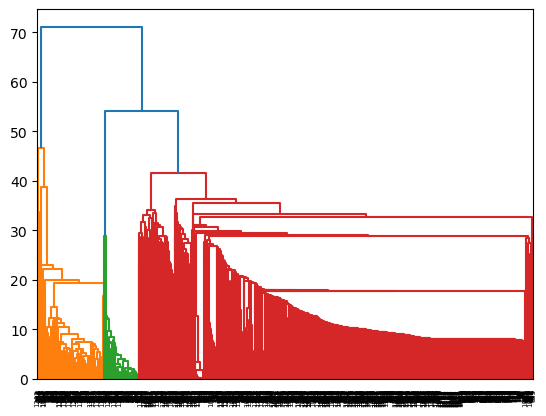

In [13]:
from scipy.cluster.hierarchy import dendrogram
dendrogram(Z)

In [63]:
Z[:10]

array([[5.20000000e+02, 5.70000000e+02, 0.00000000e+00, 2.00000000e+00],
       [2.94000000e+02, 1.00500000e+03, 1.41562919e-03, 2.00000000e+00],
       [4.70000000e+01, 7.09000000e+02, 2.13597814e-03, 2.00000000e+00],
       [5.97000000e+02, 1.14200000e+03, 3.54439489e-03, 2.00000000e+00],
       [1.00300000e+03, 1.22000000e+03, 3.74978405e-03, 3.00000000e+00],
       [1.34000000e+02, 9.13000000e+02, 7.82119114e-03, 2.00000000e+00],
       [3.53000000e+02, 8.58000000e+02, 1.41348783e-02, 2.00000000e+00],
       [8.14000000e+02, 8.39000000e+02, 1.47499131e-02, 2.00000000e+00],
       [6.13000000e+02, 1.22400000e+03, 1.84713175e-02, 3.00000000e+00],
       [2.07000000e+02, 2.32000000e+02, 2.09905516e-02, 2.00000000e+00]])

/home/hugheslab1/zfdeng/miniconda3/envs/n4j/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/hugheslab1/zfdeng/miniconda3/envs/n4j/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


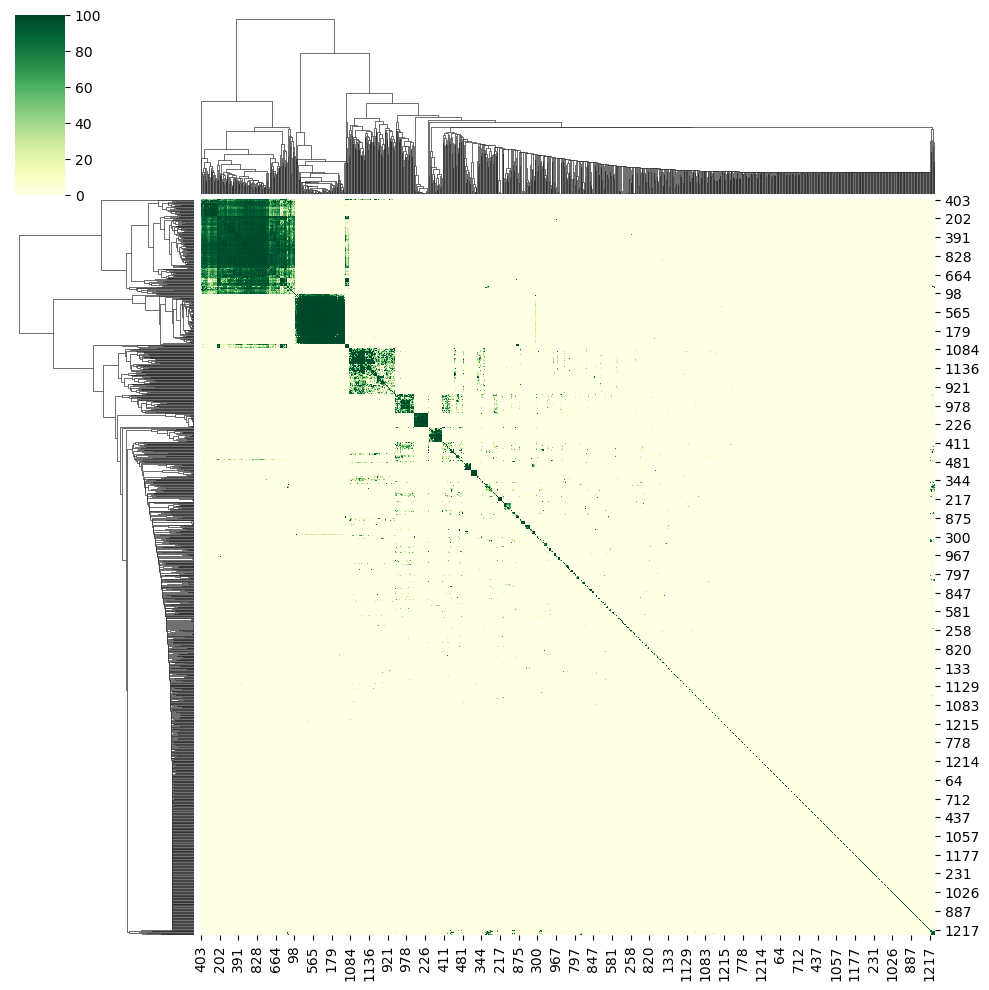

In [22]:
import seaborn as sns
from matplotlib import pyplot as plt


plt.close('all')

cmap1=sns.clustermap(sym_mat,
               cmap='YlGn',
            #    xticklabels=matrix.index,
            #    yticklabels=matrix.index,
            #    row_colors=dendro_color,
            #    col_colors=dendro_color,
               rasterized=True)
# plt.close(plt.gcf())

Measure the performance of cluster
At least: cover all Pfam clan pairs
Maybe: maximal threshold of prob to cover all Pfam clan pairs?


Jaccard similarity coefficient? (Nope)
Adjusted Rand Index, ARI
Fowlkes-Mallows Index（FMI）


In [18]:
from sklearn.preprocessing import StandardScaler
import umap
reducer = umap.UMAP()
scaled_data = StandardScaler().fit_transform(cmap1.data)
embedding = reducer.fit_transform(scaled_data)
embedding.shape

(1218, 2)

Text(0.5, 1.0, 'UMAP projection')

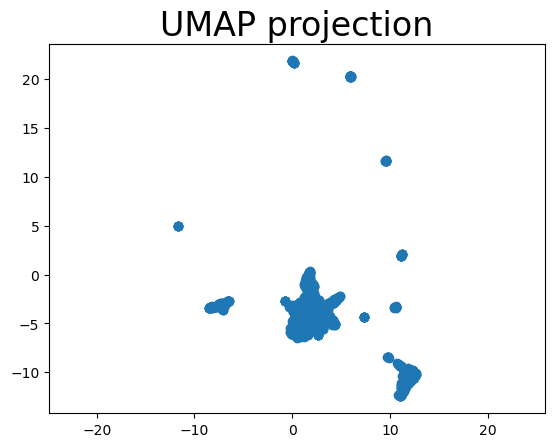

In [19]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)

In [103]:
matrix.index

Index(['PF00004', 'PF00006', 'PF00009', 'PF00025', 'PF00034', 'PF00069',
       'PF00071', 'PF00089', 'PF00096', 'PF00154',
       ...
       'PF20429', 'PF20473', 'PF20483', 'PF20485', 'PF20540', 'PF20551',
       'PF20558', 'PF20586', 'PF20591', 'PF20604'],
      dtype='object', name='query', length=1218)

In [88]:
probs['tmp'].to_numpy().T.shape

(74069,)

In [86]:
hmmaligns[0][0]

'PF19219'

In [54]:
(cct['query']+cct['domain_accession']).value_counts()

PF07219PF10300    4
PF06637PF05667    4
PF15290PF15964    4
PF05918PF10508    4
PF05918PF01602    4
                 ..
PF12847PF05175    1
PF12847PF05971    1
PF12847PF02384    1
PF12847PF03848    1
PF03109PF06315    1
Name: count, Length: 74069, dtype: int64

In [66]:
_=cct[(cct['query']=='PF06637') & (cct['domain_accession']=='PF05667')]
pd.DataFrame([_['prob'],_['end']-_['begin'],_['hmmend']-_['hmmbegin']]).T

,prob,Unnamed 0,Unnamed 1
33917,98.2,28.0,28.0
33940,97.1,13.0,13.0
33944,95.3,16.0,16.0
33997,86.2,36.0,36.0


,query,domain_accession,domain_annotation,prob,eval,pval,score,ss,begin,end,hmmbegin,hmmend,hmmlength
33917,PF06637,PF05667,CCDC22,98.2,0.00076,1.400000e-07,64.6,33.5,195,223,447,475,592
33940,PF06637,PF05667,CCDC22,97.1,0.04900,9.200000e-06,50.8,26.6,350,363,513,526,592
33944,PF06637,PF05667,CCDC22,95.3,0.33000,6.300000e-05,44.5,21.2,368,384,503,519,592
33997,PF06637,PF05667,CCDC22,86.2,5.80000,1.100000e-03,35.1,26.1,56,92,340,376,592


In [52]:
cct.pivot(index='query',columns='domain_accession',values='prob')

ValueError: Index contains duplicate entries, cannot reshape

In [18]:
hmmaligns[0][1]

[['  1 ',
  'PF19219.3 ; CoV_NSP15_N ; Coro',
  ' 100.0',
  ' 8.7E-40',
  ' 1.6E-43',
  '  193.9',
  '   6.7',
  '   61',
  '    1-61   ',
  '   1-61  ',
  '(61)'],
 ['  2 ',
  'PF06394.16 ; Pepsin-I3 ; Pepsi',
  '  21.5',
  '       9',
  '  0.0019',
  '   18.3',
  '   2.0',
  '   16',
  '   19-34   ',
  '  17-32  ',
  '(74)'],
 ['  3 ',
  'PF05436.14 ; MF_alpha_N ; Mati',
  '  21.2',
  '     8.1',
  '  0.0017',
  '   19.2',
  '   1.7',
  '   24',
  '   31-54   ',
  '  48-71  ',
  '(81)'],
 ['  4 ',
  'PF10781.12 ; DSRB ; Dextransuc',
  '  19.5',
  '     9.8',
  '  0.0018',
  '   19.3',
  '   1.5',
  '   14',
  '   27-40   ',
  '   3-16  ',
  '(61)'],
 ['  5 ',
  'PF10133.12 ; CooT ; CO dehydro',
  '  16.8',
  '      19',
  '  0.0041',
  '   16.1',
  '   2.6',
  '   14',
  '   26-39   ',
  '  17-30  ',
  '(60)'],
 ['  6 ',
  'PF19822.2 ; DUF6304 ; Family o',
  '  14.7',
  '      17',
  '  0.0037',
  '   19.6',
  '   2.4',
  '   22',
  '   10-31   ',
  '   2-23  ',
  '(170)'],
 ['  7 ',

In [15]:
hmmaligns[0][1]

[['  1 ',
  'PF19219.3 ; CoV_NSP15_N ; Coro',
  ' 100.0',
  ' 8.7E-40',
  ' 1.6E-43',
  '  193.9',
  '   6.7',
  '   61',
  '    1-61   ',
  '   1-61  ',
  '(61)'],
 ['  2 ',
  'PF06394.16 ; Pepsin-I3 ; Pepsi',
  '  21.5',
  '       9',
  '  0.0019',
  '   18.3',
  '   2.0',
  '   16',
  '   19-34   ',
  '  17-32  ',
  '(74)'],
 ['  3 ',
  'PF05436.14 ; MF_alpha_N ; Mati',
  '  21.2',
  '     8.1',
  '  0.0017',
  '   19.2',
  '   1.7',
  '   24',
  '   31-54   ',
  '  48-71  ',
  '(81)'],
 ['  4 ',
  'PF10781.12 ; DSRB ; Dextransuc',
  '  19.5',
  '     9.8',
  '  0.0018',
  '   19.3',
  '   1.5',
  '   14',
  '   27-40   ',
  '   3-16  ',
  '(61)'],
 ['  5 ',
  'PF10133.12 ; CooT ; CO dehydro',
  '  16.8',
  '      19',
  '  0.0041',
  '   16.1',
  '   2.6',
  '   14',
  '   26-39   ',
  '  17-30  ',
  '(60)'],
 ['  6 ',
  'PF19822.2 ; DUF6304 ; Family o',
  '  14.7',
  '      17',
  '  0.0037',
  '   19.6',
  '   2.4',
  '   22',
  '   10-31   ',
  '   2-23  ',
  '(170)'],
 ['  7 ',

In [14]:
parse_genome_res(hmmaligns[0])

IndexError: string index out of range